<img src="https://www.lanl.gov/_assets/images/lanl-logo-footer.png" width="210"></img>
<h1><left><font size="5">Forecasting Laboratory Earthquakes Using Seismic Acoustic Time-Series (v0)</font></left></h1>
<h2><left><font size="4">Data Source & Host: Los Alamos National Laboratory</font></left></h2>
<h3><left><font size="3">Author: DNS (Running time: ~8-10 hrs, Processsor: 8750H/6-core)</font></left></h3>



# <a id='0'>Contents</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Import Packages</a>  
- <a href='#3'>Data Exploration</a>   
- <a href='#4'>Signal Processing & Feature engineering</a>
- <a href='#5'> GBM Model</a>
- <a href='#6'>Submission File</a>  
- <a href='#7'>References</a>

# <a id='1'>Introduction</a>  

The objective is to develop and validate machine learning model(s) for predicting remaining time to tectonic failure (earthquake rupture) using seismic time-series emissions. 

Data comes from experiments conducted at Los Alamos National Laboratory wherein a biaxial double direct shear apparatus was used to simulate tectonic fault slip: "two fault gouge layers are sheared simultaneously while subjected to a constant normal load and a prescribed shear velocity. The laboratory faults fail in repetitive cycles of stick and slip that is meant to mimic the cycle of loading and failure on tectonic faults" (Rouet-Leduc et al.). 
 
Los Alamos' initial work showed that prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles. 

The data provided here is a much more challenging dataset with considerably more aperiodic earthquake failures.  The goal is to predict the failures for each test set.  


# <a id='2'>Import Packages</a>


In [1]:
import os 
import time
import csv
import warnings
import numpy as np
from numpy.fft import rfft
import pandas as pd
from tqdm import tqdm_notebook, tnrange
import lightgbm as lgb
import dask_searchcv as dcv
import dask
from scipy import stats
from scipy.signal import hann, hilbert, convolve 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold, learning_curve, GridSearchCV
from collections import deque, defaultdict
from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")
pd.options.display.precision = 10
%matplotlib inline

# <a id='3'>Data Exploration</a>  

Training Data:
   - +600M samples 
    
   - Two fields: 
       - acoustic_data: amplitude of seismic signal per sample
       - time_to_failure: remaining time to tectonic failure
   - no null/missing values
   
Submission/Test Data:
   - 2624 Files/150,000 samples per file  
   
   - One field:
       - acoustic_data


### Training Data

In [2]:
%%time
data = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

Wall time: 1min 38s


In [3]:
print('Dimension:', data.shape)
data.isnull().sum()

Dimension: (629145480, 2)


acoustic_data      0
time_to_failure    0
dtype: int64

### Plotting

Given very large dataset size, plot ~5% (~30 Million Samples) of the data:

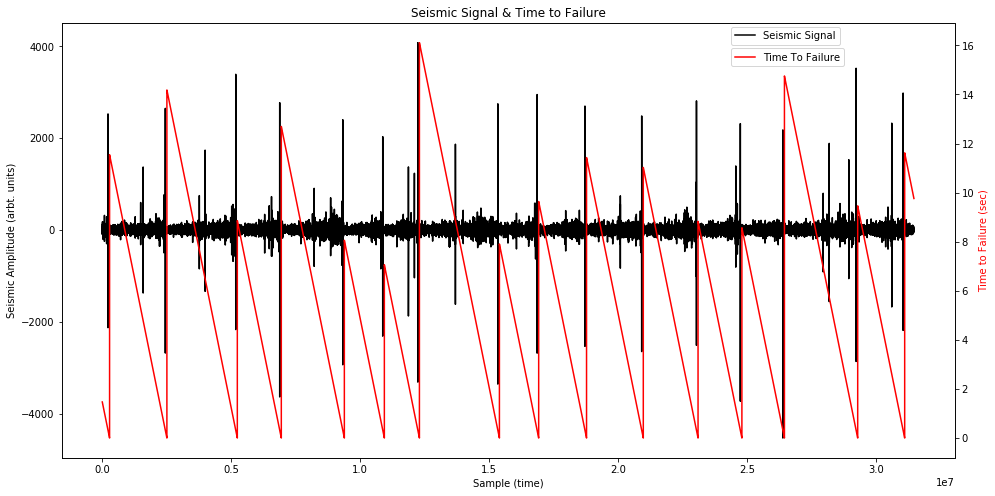

In [4]:
fig = plt.figure(figsize=(16,8))

plt.title('Seismic Signal & Time to Failure')
plt.xlabel('Sample (time)')

ax1 = plt.axes()
ax1.plot(data.iloc[::20,0].values, color='k', label='Seismic Signal')
ax1.set_ylabel('Seismic Amplitude (arbt. units)', color='k')
plt.legend(loc=(0.75, 0.95))

ax2 = ax1.twinx()
ax2.plot(data.iloc[::20,1].values, 'r', label='Time To Failure')
ax2.set_ylabel('Time to Failure (sec)', color='r')
plt.legend(loc=(0.75, 0.90))

### Plot Analysis

Time to failure reaches a minimum of 0 seconds in close alignment with spikes in the seismic amplitude (occurs 16 times within the recorded data); however, not every spike in amplitude coincides with an earthquake event as there appears inter-event releases of seismic energy in between failures. 

The range of amplitude osciallations appears to grow with approaching time to failure (Rouet-Leduc et al.), signifying power of the seismic signal may be a strong predictor for time to failure.   

### Test/Submission Data 

In [5]:
path = './test'
test_data1 = pd.read_csv(path+'/'+os.listdir(path)[0])
print('Dimension:', test_data1.shape)
print('Number of test files:', len(os.listdir(path)))
test_data1.isnull().sum()

Dimension: (150000, 1)
Number of test files: 2624


acoustic_data    0
dtype: int64

In [88]:
lengths = defaultdict(int)
 
for filename in tqdm_notebook(os.listdir(path), desc='Checking Test File Sizes:'):
    x = pd.read_csv(path + '/' + filename)
    lengths[x.shape[0]] += 1

print('Test Files Sizes:')
for k in lengths:
    print('Number of Files:',lengths[k], ' Rows:', k)


Test Files Dimensions:
Number of Files: 2624  Rows: 150000


In [6]:
del data, test_data1

# <a id='4'>Signal Processing & Feature engineering</a>  

Given training data is very large (600M+ Samples/9GBs) read in data in 150,000 sample chunks (test files size). Designate float32 instead of float64 for target (time_to_failure); compute features for each chunk, append to features_matrix file on disk, increment through data file in 4000 sample chunks (~97% window overlap).

### Statistical Features

    Initial Subwindow Features:
    - power
    - mean
    - skew 
    - kurtosis 
    - 1st and 2nd derivative features
    - RFFT coefficients

In [698]:
def get_sub_features(signal):
    
    def power(sig):
        return sum(map(lambda x: x**2, sig))/len(sig)
        
    features = pd.DataFrame({'power': power(signal),
                             'mean': signal.mean(),
                             'skew': signal.skew(),
                             'kurtosis': stats.kurtosis(signal, fisher=False)}, index=[0])
    return features

In [699]:
def get_features(raw_signal):
    features_whole = get_sub_features(raw_signal)
        
    features_1st_third = get_sub_features(raw_signal[0:50_000]).astype('float32')
    features_2nd_third = get_sub_features(raw_signal[50_000:100_000]).astype('float32')
    features_3rd_third = get_sub_features(raw_signal[100_000:]).astype('float32')

    first_derivative_features_1 = features_2nd_third - features_1st_third
    first_derivative_features_2 = features_3rd_third - features_2nd_third

    second_derivative_features = first_derivative_features_2 - first_derivative_features_1

    features_rec = pd.concat([features_1st_third,
                              features_2nd_third,
                              features_3rd_third,
                              first_derivative_features_1,
                              first_derivative_features_2,
                              second_derivative_features], axis=1)

    output = pd.concat([features_whole, features_rec], axis=1)
    
    return output 

In [391]:
reader = pd.read_csv('train.csv', iterator=True, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

window = reader.get_chunk(150_000)
raw_signal = window.acoustic_data
target = [] 

with open('features_matrix.csv', 'a', newline = '') as f:
    feature_names = ['power', 'mean', 'skew', 'kurtosis',
                     'power1', 'mean1', 'skew1', 'kurtosis1', 
                     'power2', 'mean2', 'skew2', 'kurtosis2',
                     'power3', 'mean3', 'skew3', 'kurtosis3',
                     'd1power1', 'd1mean1', 'd1skew1', 'd1kurtosis1',
                     'd1power2', 'd1mean2', 'd1skew2', 'd1kurtosis2',
                     'd2power', 'd2mean', 'd2skew', 'd2kurtosis']
    wr = csv.writer(f)
    wr.writerow(feature_names)
    
    interval = 4_000
    iterations = (629_145_480-150_000)//interval + 1
    
    for _ in tqdm_notebook(range(iterations), desc='Feature Extraction'):
        
        target.append(window.time_to_failure.iloc[-1])

        train_row = get_features(raw_signal)
        train_row.to_csv(f, index=False, header=False)
        
        try:
            window = reader.get_chunk(interval)
        except:
            continue 
        
        raw_signal = raw_signal[interval:].append(window.acoustic_data)
                    
pd.Series(target).to_csv('target.csv',index=False)

In [536]:
features_matrix = pd.read_csv('features_matrix.csv')

In [537]:
target = pd.read_csv('target.csv', header=None )

###  Fast Fourier Transform

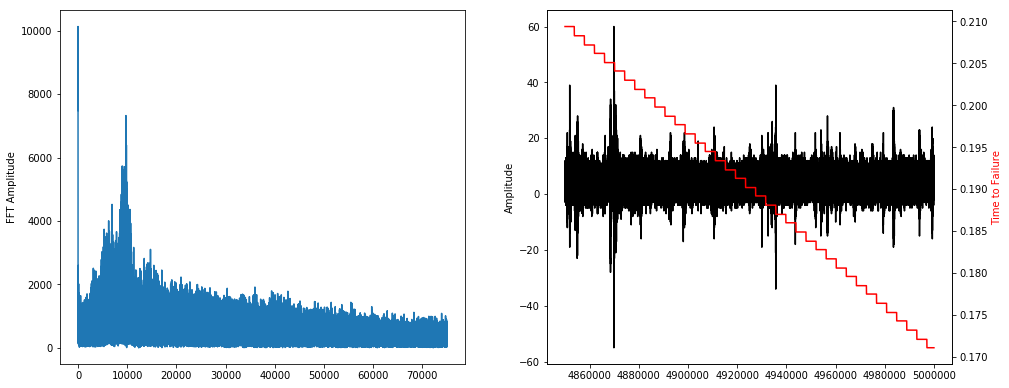

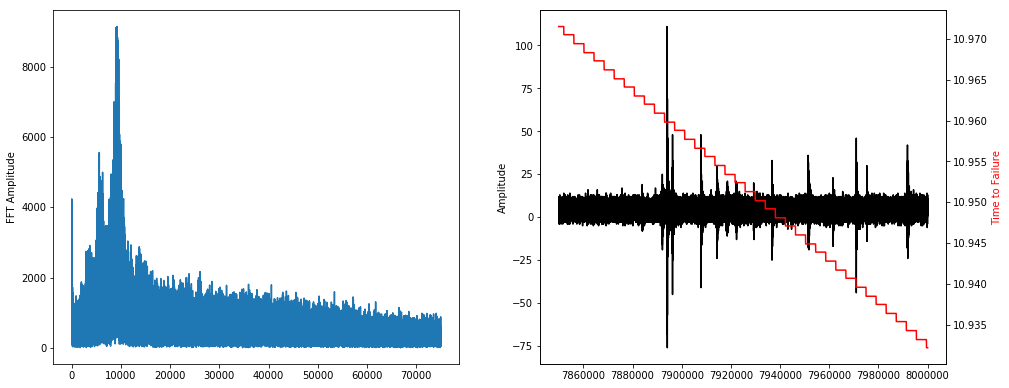

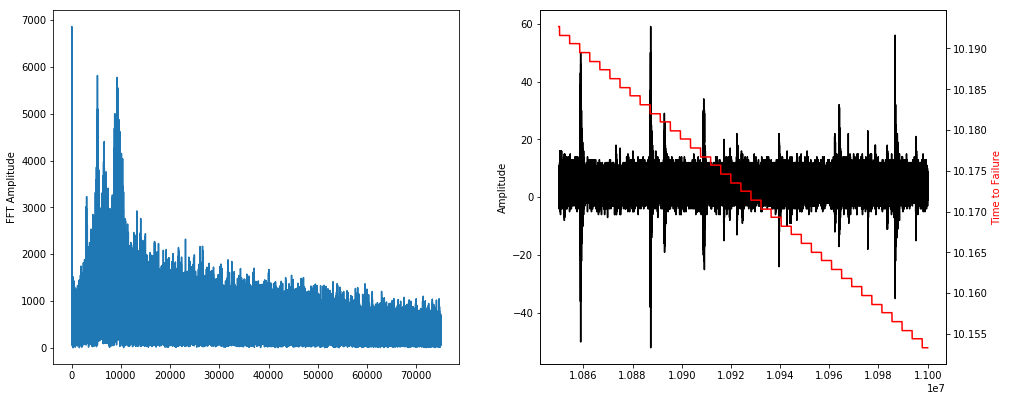

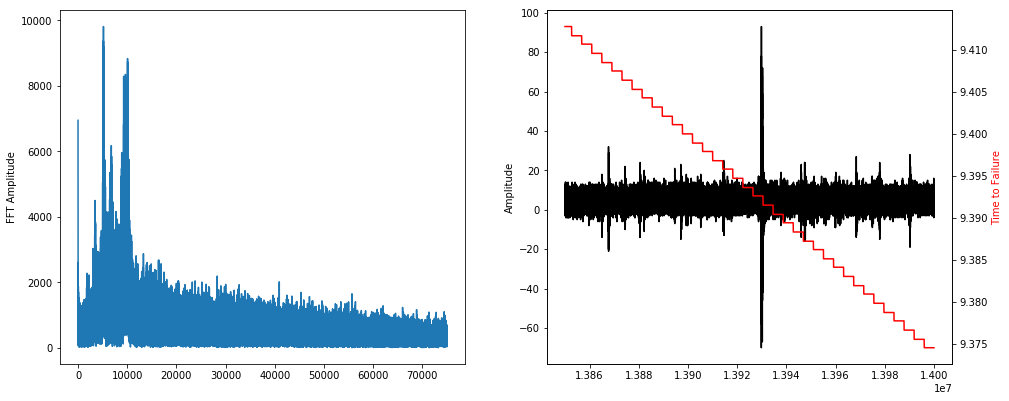

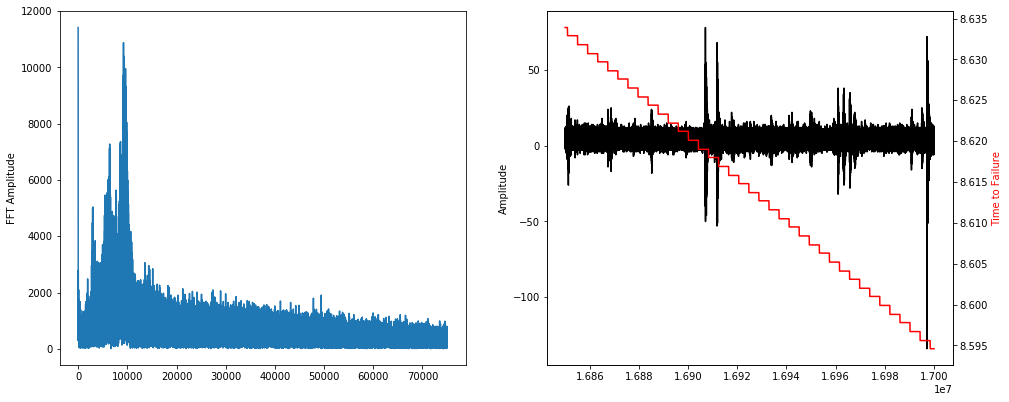

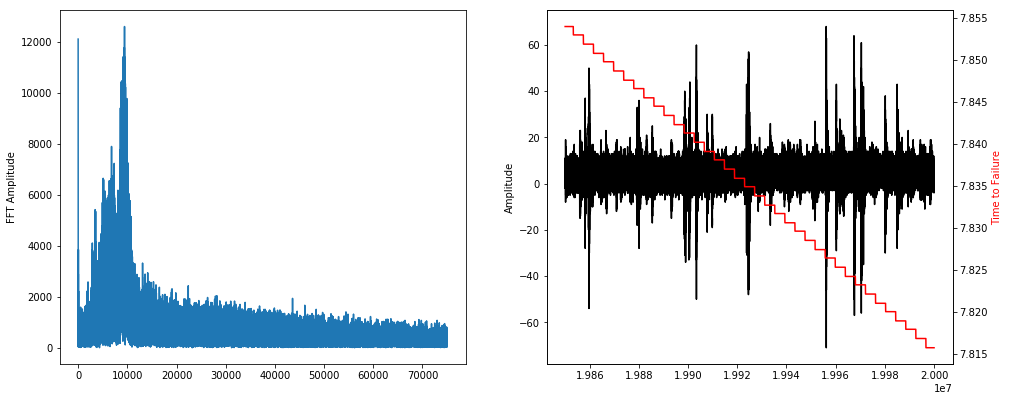

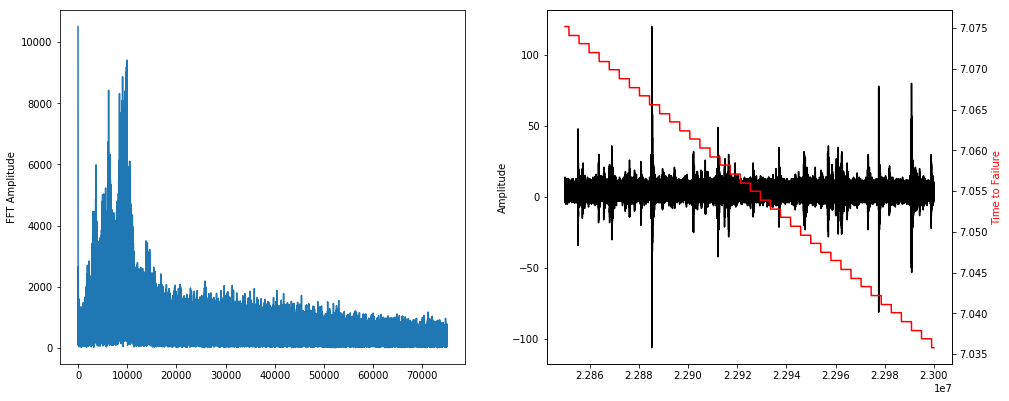

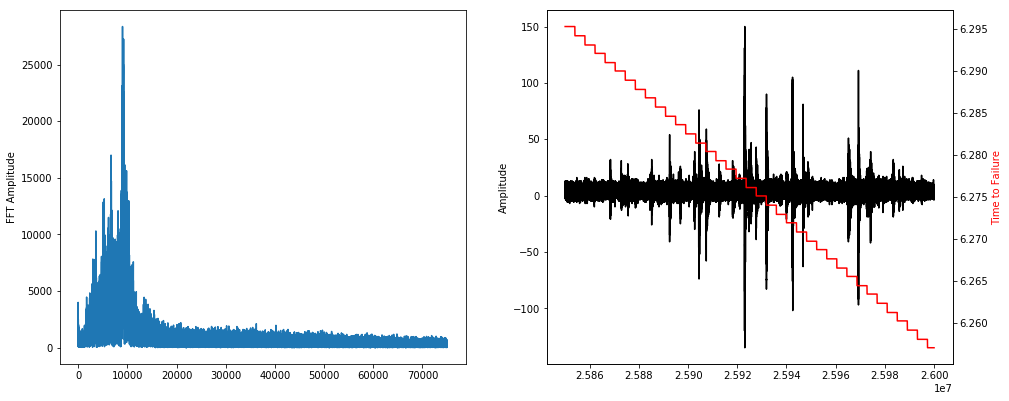

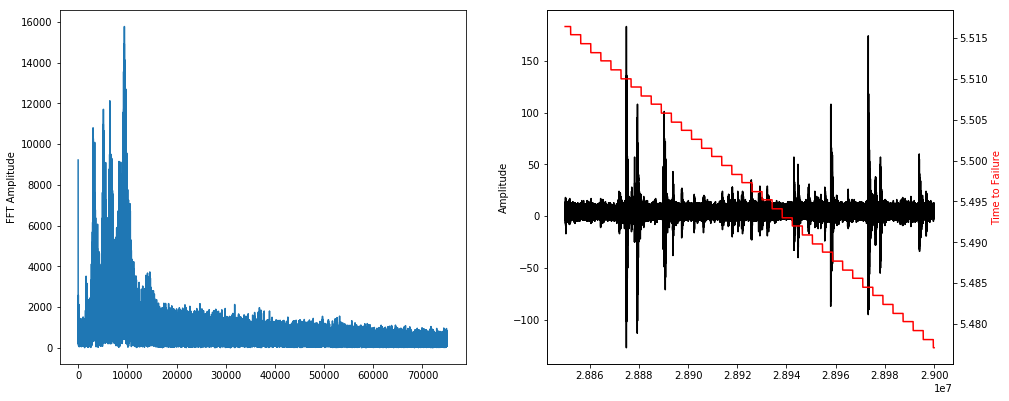

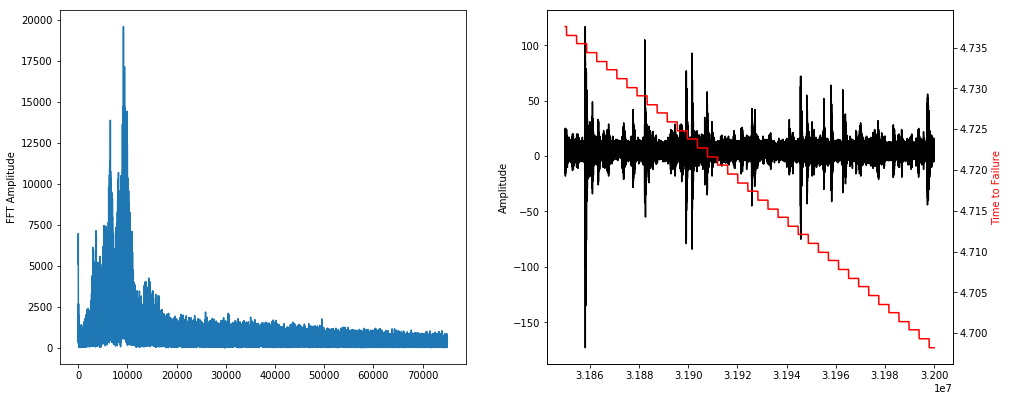

In [6]:
reader = pd.read_csv('train.csv', iterator=True, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
window = reader.get_chunk(2_000_000)

for i in tqdm_notebook(range(10), desc='Plotting FFT\'s'):
    for _ in range(20):
        window = reader.get_chunk(150_000)
    trans_signal = (window.acoustic_data-window.acoustic_data.mean())*hann(150_000)
    fourier = np.fft.rfft(trans_signal)
    fig, axs = plt.subplots(1, 2, figsize=(16,6.5))
    axs[0].plot(range(1,75_001), abs(fourier[1:]))
    axs[0].set_ylabel('FFT Amplitude')
    #axs[0].set_xlim([-.0001,20000])
    ax2 = axs[1].twinx()
    ax2.set_ylabel('Time to Failure', color='r')
    axs[1].set_ylabel('Amplitude')
    axs[1].plot(window.acoustic_data, color='k')
    #axs[1].set_xlim([-.0001,1e4])
    ax2.plot(window.time_to_failure, color = 'r')

Throughout the failure cycle, the FFT is dominated by lower frequencies; in order to fit all FFT training samples into memory (and compute SVD for dimensionality reduction), approximately 16,700 components of the 75,000 will be preserved per sample. 

In [568]:
def get_fourier(signal):
    trans_signal = (signal-signal.mean())*hann(150_000)
    # compute real FFT and take lower frequnecies of interest
    coefficients = np.fft.rfft(trans_signal)[1:16668]
    return abs(coefficients)

In [569]:
reader = pd.read_csv('train.csv', iterator=True, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
iterations = 629_145_480//150_000
fourier_matrix = np.zeros((iterations,16_667))

for i in tqdm_notebook(range(iterations), desc='Computing FFT\'s'):
    window = reader.get_chunk(150_000)
    fourier_matrix[i,:] = get_fourier(window.acoustic_data)  

### Dimensionality Reduction (Principal Component Analysis) of FFT

In [570]:
dim_reduction = PCA(n_components=0.95)
dim_reduction.fit(fourier_matrix)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [579]:
dim_reduction.n_components_

243

In [578]:
dim_reduction.explained_variance_ratio_

array([7.17728253e-01, 3.68502844e-02, 2.82181780e-02, 2.45335700e-02,
       1.97147006e-02, 1.69597808e-02, 1.32701123e-02, 1.26610015e-02,
       7.41816780e-03, 4.82366108e-03, 4.49959533e-03, 3.73787773e-03,
       3.42688018e-03, 2.93475683e-03, 2.74923519e-03, 2.59545452e-03,
       2.23853806e-03, 1.98029372e-03, 1.91651016e-03, 1.55705623e-03,
       1.49277493e-03, 1.44479704e-03, 1.35270800e-03, 1.28642279e-03,
       1.12975436e-03, 1.08063941e-03, 9.78998392e-04, 9.33165645e-04,
       8.58562392e-04, 8.05581507e-04, 7.70416111e-04, 7.10384548e-04,
       6.50732350e-04, 6.30881998e-04, 6.05853724e-04, 5.70104791e-04,
       5.38282341e-04, 5.26370557e-04, 4.95272377e-04, 4.78334082e-04,
       4.49886383e-04, 4.46026361e-04, 4.26860020e-04, 4.15040211e-04,
       3.92159242e-04, 3.64277402e-04, 3.46844054e-04, 3.41301621e-04,
       3.27695958e-04, 3.21489486e-04, 2.97008159e-04, 2.86465974e-04,
       2.83026839e-04, 2.78114187e-04, 2.56187443e-04, 2.46605802e-04,
      

A total of 243 components were calcualted to preserve 95% variance of the first ~16,700 FFT coefficients. First principal component captures ~71% of the variance, second component ~4%, third component ~3%, etc. 
In total, reduction of 16,700 features into 243 components will save a lot of computational time. 

In [581]:
reader = pd.read_csv('train.csv', iterator=True, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
interval = 4_000
iterations = (629_145_480-150_000)//interval + 1

fourier_matrix = np.zeros((iterations, dim_reduction.n_components_))
window = reader.get_chunk(150_000)
raw_signal = window.acoustic_data

for i in tqdm_notebook(range(iterations), desc='PCA(FFT)'):
        fourier_matrix[i,:] = dim_reduction.transform(get_fourier(raw_signal).reshape(1,-1))
         
        try:
            window = reader.get_chunk(interval)
        except:
            continue 
        
        raw_signal = raw_signal[interval:].append(window.acoustic_data)

In [584]:
np.savetxt("features_fourier_PCA.csv", fourier_matrix, delimiter=",")

# <a id='5'>GBM Model</a> 

Train Gradient Boosting Tree models using simplifed (28) feature matrix, cross-validate, assess error:

In [611]:
param_grid = {'learning_rate': [0.01, 0.03, 0.1, 0.3], 
              'num_leaves':[31,100,300],
              'min_data_in_leaf': [100, 300, 1000],
              'n_estimators': [100,300,1000]}

In [617]:
model = GridSearchCV(estimator=lgb.LGBMRegressor(), 
                     param_grid=param_grid, 
                     cv=6, 
                     scoring='neg_mean_absolute_error',
                     n_jobs=-1,
                     verbose=10,
                     return_train_score=True)

In [619]:
model.fit(features_matrix,target)

Fitting 6 folds for each of 108 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 3

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3], 'num_leaves': [31, 100, 300], 'min_data_in_leaf': [100, 300, 1000], 'n_estimators': [100, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

### Training & CV Error Analysis

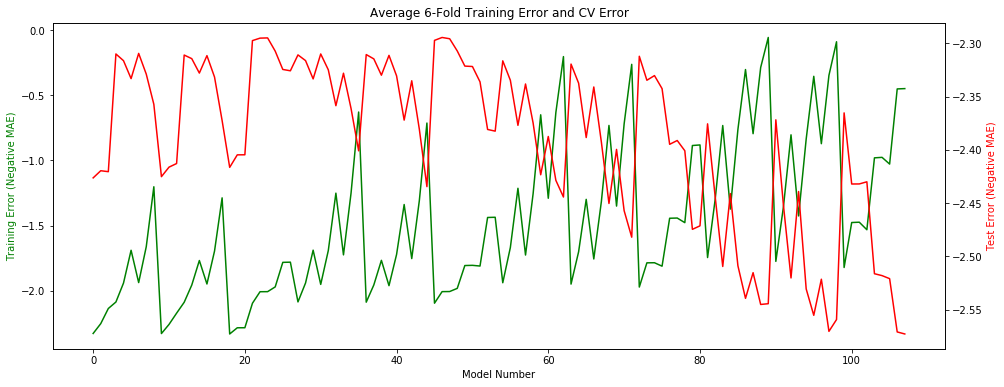

In [648]:
fig = plt.figure(figsize=(16,6))
plt.title('Average 6-Fold Training Error and CV Error')
plt.xlabel('Model Number')
ax1 = plt.axes()
ax2 = ax1.twinx()

ax1.plot(model.cv_results_['mean_train_score'], color='g')
ax1.set_ylabel('Training Error (Negative MAE)',color='g')

ax2.plot(model.cv_results_['mean_test_score'], color='r')
ax2.set_ylabel('Test Error (Negative MAE)',color='r');

In [655]:
model.best_params_

{'learning_rate': 0.03,
 'min_data_in_leaf': 1000,
 'n_estimators': 100,
 'num_leaves': 100}

A total of 108 gradient boosting tree models were trained and validated with various parameters. Mean training fold error and cross validation error were plotted for all models; each model show a slight trend of overfitting, with the training error being unanimously lower than cv error. The grid search produced the best parameters as:   

- learning rate: 0.03 
- min_data_in_leaf: 1000
- n_estimators: 100
- num_leaves: 100

Interestingly, with a low learning rate of 0.03 the optimal number of trees was only 100, signifying relatively deep/complex trees were produced at each iteration. Based on this, I assume a fair degree of improvement to be had in tuning the parameters of the model, even without adding additional features; both will be done in the next modelling iteration.  

### Feature Importance

Text(0.5, 1.0, 'Feature Importance')

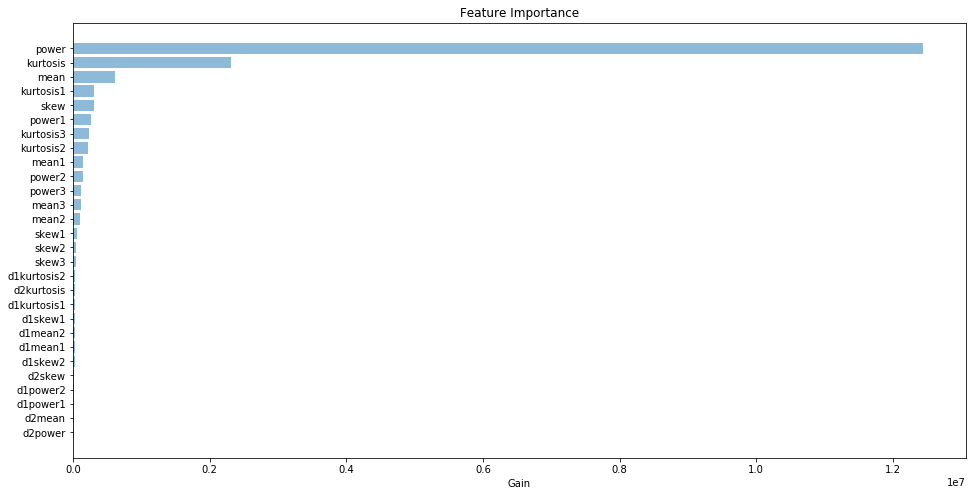

In [670]:
M1 = lgb.LGBMRegressor(learning_rate=0.03, min_data_in_leaf=1000, n_estimators=100, num_leaves=100, importance_type='gain')
M1.fit(features_matrix, target)
ranked_features_ndx = sorted(range(len(M1.feature_importances_)), key=lambda x: M1.feature_importances_[x])


objects = [features_matrix.keys()[i] for i in ranked_features_ndx]
y_pos = np.arange(len(objects))
importance = [M1.feature_importances_[i] for i in ranked_features_ndx]

fig = plt.figure(figsize=(16,8))
plt.barh(y_pos, importance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Gain')
plt.title('Feature Importance')

Feature importance is ranked by the contribution to gain in the cost(loss) function; replicating the findings of Rouet-Leduc et al., power(energy) of the seismic signal seems to be the single most important feature for predicting time to tectonic failure; kurtosis was a distant second, and mean/DC of the signal, third. Ranking will be useful for reconstructing a new feature matrix, namely removing the derivative features and potentially resizing subwindows; FFT components will also be incorporated into a new feature matrix.

# <a id='6'>Submission File</a>  

In [726]:
path = './test'
with open('submission.csv', 'a', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(['seg_id','time_to_failure'])
    
    for seg in tqdm_notebook(os.listdir(path), desc='Creating Submission'):
        data = pd.read_csv(path+'/'+seg).acoustic_data
        features_vector = get_features(data)
        model_y = model.predict(features_vector.values.reshape(1,-1))
        wr.writerow([seg.split('.')[0] , model_y[0]])

# <a id='7'>References</a>  

1. Hulbert, Claudia & Rouet-Leduc, Bertrand & A. Johnson, Paul & Ren, Christopher & Rivière, Jacques & C. Bolton, David & Marone, Chris. (2019). Similarity of fast and slow earthquakes illuminated by machine learning. Nature Geoscience. 12. 10.1038/s41561-018-0272-8. 


2. Rouet-Leduc, Bertrand & L. Hulbert, Claudia & Lubbers, Nicholas & M. Barros, Kipton & Humphreys, Colin & A. Johnson, Paul. (2017). Machine Learning Predicts Laboratory Earthquakes. Geophysical Research Letters. 44. 10.1002/2017gl074677.


3. Rouet-Leduc, Bertrand & Hulbert, Claudia & C. Bolton, David & Ren, Christopher & Rivière, Jacques & Marone, Chris & Guyer, Robert & A. Johnson, Paul. (2018). Estimating Fault Friction From Seismic Signals in the Laboratory. Geophysical Research Letters. 45. 10.1002/2017gl076708. 